In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, Add
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# Load Data
train_data_path = "data/train.csv"

train_set = pd.read_csv(train_data_path)

In [5]:
train_set.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
train_set.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y = train_set[train_set.columns[2:]]
list_sentences_train = train_set["comment_text"]

In [8]:
Y.shape, list_sentences_train.shape

((159571, 6), (159571,))

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:

1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

Fortunately, Keras has made our lives so much easier. If you are using the vanilla Tensorflow, you probably need to implement your own dictionary structure and handle the indexing yourself. In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences.

### Let's treat the text and get extra features

1. Get extra features

In [9]:
comment_list = list(list_sentences_train)

In [10]:
class FeatureExtractor:
    
    def __init__(self, punctuation_set):
        self.punctuation_set = punctuation_set
        
    def extract_features(self, comments_list):
        """ This function aims at extracting features from 
        list of comments
        1. remove \n
        2. Count number of punctuation then divide it by letter number in doc
        3. Count number of capital letter then divide it by letter number in doc
        4. Count unique_words_nb / nb_words
        5. Count 
        """
        sentences_count = []
        punctuation_list = []
        capital_letters_list = []
        unique_words_list = []
        for comment in comments_list:
            sentences_count.append(len(re.findall("\n",str(comment)))+1)
            clean_comment = comment.replace('\n', ' ')
            nb_letters = len(clean_comment.replace(' ', ''))
            punctuation_list.append(sum(map(clean_comment.count, self.punctuation_set))/nb_letters)
            capital_letters_list.append(len(re.findall(r'[A-Z]', clean_comment))/nb_letters)
            unique_words_list.append(len(set(clean_comment.split()))/len(clean_comment.split()))
        return sentences_count, punctuation_list, capital_letters_list, unique_words_list
            
        

In [11]:
feature_extractor = FeatureExtractor(set(string.punctuation))
sentences_count, punctuation_list, capital_letters_list, unique_words_list = feature_extractor.extract_features(comment_list)

In [12]:
df_list_sentences_train = list_sentences_train.to_frame()
df_list_sentences_train['nb_sentences'] = sentences_count
df_list_sentences_train['nb_punctuation'] = punctuation_list
df_list_sentences_train['nb_capital'] = capital_letters_list
df_list_sentences_train['nb_unique_words'] = unique_words_list

In [13]:
df_list_sentences_train.head(10)

,comment_text,nb_sentences,nb_punctuation,nb_capital,nb_unique_words
0,Explanation\nWhy the edits made under my usern...,2,0.045045,0.076577,0.953488
1,D'aww! He matches this background colour I'm s...,1,0.126316,0.084211,1.000000
2,"Hey man, I'm really not trying to edit war. It...",1,0.031250,0.020833,0.928571
3,"""\nMore\nI can't make any real suggestions on ...",5,0.041420,0.021696,0.725664
4,"You, sir, are my hero. Any chance you remember...",1,0.090909,0.036364,1.000000
5,"""\n\nCongratulations from me as well, use the ...",3,0.076923,0.019231,0.923077
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0.000000,1.000000,1.000000
7,Your vandalism to the Matt Shirvington article...,1,0.042105,0.042105,1.000000
8,Sorry if the word 'nonsense' was offensive to ...,1,0.048718,0.017949,0.843373
9,alignment on this subject and which are contra...,1,0.000000,0.033898,1.000000


In [14]:
fixed_features = df_list_sentences_train[df_list_sentences_train.columns[1:]]
fixed_features.head()

,nb_sentences,nb_punctuation,nb_capital,nb_unique_words
0,2,0.045045,0.076577,0.953488
1,1,0.126316,0.084211,1.000000
2,1,0.031250,0.020833,0.928571
3,5,0.041420,0.021696,0.725664
4,1,0.090909,0.036364,1.000000


In [15]:
max_features = 20000
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

In [16]:
len(tokenizer.word_index)

210337

But there's still 1 problem! What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features) isn't it?


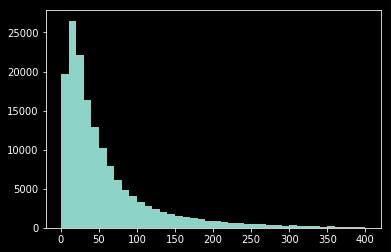

In [17]:
total_words_in_docs = [len(doc) for doc in list_tokenized_train]
plt.hist(total_words_in_docs,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [18]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [19]:
X_t.shape, fixed_features.as_matrix().shape

((159571, 300), (159571, 4))

In [20]:
X_final = np.concatenate((X_t, fixed_features.as_matrix()), axis=1)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_final, Y, test_size=0.1)
X_train.shape, X_val.shape, len(Y_train), len(Y_val) 

((143613, 304), (15958, 304), 143613, 15958)

In [24]:
X_train[15:79, maxlen:].shape

(64, 4)

In [180]:
class DataGenerator:
    
    def __init__(self):
        self.index_train = 0
        self.index_val = 0
    
    def generate_data(self, batch_size, train):
        while True:
            comments = []
            fixed_features = []
            labels = []
            if train:
                if self.index_train + batch_size < len(X_train): 
                    comments.append(X_train[self.index_train:self.index_train + batch_size, :maxlen])
                    fixed_features.append(X_train[self.index_train:self.index_train + batch_size, maxlen:])
                    labels.append(Y_train[self.index_train:self.index_train + batch_size])
                    self.index_train += batch_size
                else:
                    rest_train = (self.index_train + batch_size) % len(X_train)
                    comments = [np.append(X_train[self.index_train:, :maxlen], X_train[:rest_train, :maxlen], axis=0)]
                    fixed_features = [np.append(X_train[self.index_train:, maxlen:], X_train[:rest_train, maxlen:], axis=0)]
                    labels = [np.append(Y_train[self.index_train:], Y_train[:rest_train], axis=0)]
                    self.index_train = rest_train
            else:
                if self.index_val + batch_size < len(X_val): 
                    comments.append(X_val[self.index_val:self.index_val + batch_size, :maxlen])
                    fixed_features.append(X_val[self.index_val:self.index_val + batch_size, maxlen:])
                    labels.append(Y_val[self.index_val:self.index_val + batch_size])
                    self.index_val += batch_size
                else:
                    rest_val = (self.index_val + batch_size) % len(X_val)
                    comments = [np.append(X_val[self.index_val:, :maxlen], X_val[:rest_val, :maxlen], axis=0)]
                    fixed_features = [np.append(X_val[self.index_val:, maxlen:], X_val[:rest_val, maxlen:], axis=0)]
                    labels = [np.append(Y_val[self.index_val:], Y_val[:rest_val], axis=0)]
                    self.index_val = rest_val
            yield [np.array(comments).reshape(batch_size, maxlen), np.array(fixed_features).reshape(batch_size, 4)], labels

### Define Keras model

In [181]:
embed_size = 128
comment_layer_input = Input(shape=(maxlen,))
comment_layer_embed = Embedding(input_dim=max_features, output_dim=embed_size)(comment_layer_input)
comment_layer_gru = GRU(32, return_sequences=True, name='gru_layer')(comment_layer_embed)
comment_layer = GlobalMaxPool1D()(comment_layer_gru)
comment_layer = Dropout(0.2)(comment_layer)


In [182]:
fixed_features_input = Input(shape=(4,))
fixed_features_dense_layer = Dense(units=32, activation='relu')(fixed_features_input)

In [183]:
merge_layer = Add()([comment_layer, fixed_features_dense_layer])
global_dense_layer = Dense(64, activation="relu")(merge_layer)
global_dense_layer = Dropout(0.2)(global_dense_layer)
output = Dense(len(list_classes), activation="sigmoid")(global_dense_layer)

In [184]:
model = Model(inputs=[comment_layer_input, fixed_features_input], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 300, 128)     2560000     input_16[0][0]                   
__________________________________________________________________________________________________
gru_layer (GRU)                 (None, 300, 32)      15456       embedding_8[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_8 (GlobalM (None, 32)           0           gru_layer[0][0]                  
__________________________________________________________________________________________________
input_17 (

In [185]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5)
callbacks_list = [earlystop]

In [186]:
data_generator = DataGenerator()

In [187]:
batch_size = 32
epochs = 50
model_info = model.fit_generator(data_generator.generate_data(batch_size, True),
                        samples_per_epoch=200, nb_epoch=epochs,
                        validation_data=data_generator.generate_data(
                            batch_size, False),
                        validation_steps=150, callbacks=callbacks_list)

/home/guillaume/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/home/guillaume/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., validation_steps=150, validation_data=<generator..., epochs=50, steps_per_epoch=200)`
  import sys


Epoch 1/50
 81/200 [===========>..................] - ETA: 38s - loss: 0.3059 - acc: 0.9089

KeyboardInterrupt: 

In [26]:
input_layer = Input(shape=(maxlen,))

In [27]:
embed_size = 128
embed_layer = Embedding(max_features, embed_size)(input_layer)

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

In [28]:
x = LSTM(32, return_sequences=True, name='lstm_layer')(embed_layer)

In [29]:
x = GlobalMaxPool1D()(x)

In [30]:
x = Dropout(0.2)(x)

In [31]:
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

In [32]:
x = Dense(len(list_classes), activation="sigmoid")(x)

In [34]:
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 300, 32)           20608     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [36]:
data_generator = DataGenerator()

In [37]:
batch_size = 32
epochs = 50
model_info = model.fit_generator(data_generator.generate_data(batch_size,True),
                        samples_per_epoch=200, nb_epoch=epochs,
                        validation_data=data_generator.generate_data(
                            batch_size, False),
                        validation_steps=150, callbacks=callbacks_list)

/home/guillaume/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/home/guillaume/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., validation_steps=150, validation_data=<generator..., steps_per_epoch=200, epochs=20)`
  import sys


Epoch 1/20
200/200 [==============================] - 91s 454ms/step - loss: 0.2111 - acc: 0.9516 - val_loss: 0.1490 - val_acc: 0.9612
Epoch 2/20
200/200 [==============================] - 84s 422ms/step - loss: 0.1540 - acc: 0.9604 - val_loss: 0.1289 - val_acc: 0.9656
Epoch 3/20
200/200 [==============================] - 84s 421ms/step - loss: 0.1330 - acc: 0.9639 - val_loss: 0.1137 - val_acc: 0.9629
Epoch 4/20
200/200 [==============================] - 90s 448ms/step - loss: 0.0974 - acc: 0.9677 - val_loss: 0.0710 - val_acc: 0.9766
Epoch 5/20
200/200 [==============================] - 72s 362ms/step - loss: 0.0666 - acc: 0.9771 - val_loss: 0.0553 - val_acc: 0.9816
Epoch 6/20
200/200 [==============================] - 80s 399ms/step - loss: 0.0574 - acc: 0.9798 - val_loss: 0.0524 - val_acc: 0.9819
Epoch 7/20
200/200 [==============================] - 90s 450ms/step - loss: 0.0615 - acc: 0.9802 - val_loss: 0.0624 - val_acc: 0.9772
Epoch 8/20
200/200 [==============================] - 9

In [40]:
model.evaluate(X_val, Y_val)

15958/15958 [==============================] - 53s 3ms/step


[0.052242176868941254, 0.98128419165803105]